### The correlation of observed precipitation data with dry spells
This notebook explores the correlation between observed precipitation and dry spells. 
The goal of the analysis is to see if, given perfect forecasting skill, there is information in the forecasted quantities for forecasting dryspells.
This notebook focuses on the observation of below average seasonal and monthly precipitation
For the seasonal and monthly precipitation as well as for the dry spells, CHIRPS is used as data source. The occurence of seasonal and monthly below average precipitation is computed in `mwi_obsprecip.ipynb`, and the dry spells are computed in `mwi_chirps_dry_spell_detection.R`

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

### set general variables and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


#### Set config values

In [4]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [5]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Load dry spell data

In [6]:
df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","dry_spells_during_rainy_season_list_2000_2020.csv")) 

In [7]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region
0,MW101,Chitipa,2008,2009-04-08,2009-04-25,18,0.0,Northern
1,MW103,Nkhata Bay,2002,2003-04-13,2003-04-30,18,0.0,Northern
2,MW103,Nkhata Bay,2008,2009-04-06,2009-05-02,27,0.0,Northern
3,MW103,Nkhata Bay,2011,2012-04-19,2012-05-02,14,0.0,Northern
4,MW103,Nkhata Bay,2017,2018-04-17,2018-04-30,14,0.0,Northern
...,...,...,...,...,...,...,...,...
159,MW315,Blantyre City,2010,2011-04-10,2011-05-19,40,0.0,Southern
160,MW315,Blantyre City,2012,2013-03-21,2013-04-03,14,0.0,Southern
161,MW315,Blantyre City,2014,2015-04-01,2015-04-14,14,0.0,Southern
162,MW315,Blantyre City,2018,2019-03-21,2019-04-16,27,0.0,Southern


In [8]:
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["ds_fd_m"]=df_ds.dry_spell_first_date.dt.to_period("M")

In [9]:
#for now only want to know if a dry spell occured in a given month, so drop those that have several dry spells confirmed within a month
df_ds_drymonth=df_ds.drop_duplicates(["ADM2_EN","ds_fd_m"]).groupby(["ds_fd_m","ADM2_EN"],as_index=False).agg("count")[["ds_fd_m","ADM2_EN","dry_spell_first_date"]] #["ADM2_EN"]

#### Load historical seasonal below average rainfall
And remove seasons outside the rainy season
For now, only including the seasons that are completely within the rainy season

In [10]:
df_belowavg_seas=pd.read_csv(os.path.join(country_data_processed_dir,"observed_belowavg_precip","chirps_seasonal_below_average_precipitation.csv"))
df_belowavg_seas.date_month=pd.to_datetime(df_belowavg_seas.date_month).dt.to_period("M")

In [11]:
#path to data start and end rainy season
df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020.csv"))
df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [12]:
df_rain[df_rain.ADM2_EN=="Balaka"]

,ID,pcode,ADM2_EN,season_approx,onset_date,onset_month,cessation_date,cessation_month,rainy_season_duration,rainy_season_rainfall,region
616,1.0,MW312,Balaka,1999,NaT,NaN,2000-04-26,4.0,NaN,NaN,Southern
617,1.0,MW312,Balaka,2000,2000-11-01,11.0,2001-04-16,4.0,167.0,1967.2,Southern
618,1.0,MW312,Balaka,2001,2001-11-01,11.0,2002-04-28,4.0,179.0,1803.7,Southern
619,1.0,MW312,Balaka,2002,2002-12-10,12.0,2003-04-15,4.0,127.0,1655.7,Southern
620,1.0,MW312,Balaka,2003,2003-11-28,11.0,2004-03-27,3.0,121.0,1328.1,Southern
621,1.0,MW312,Balaka,2004,2004-11-06,11.0,2005-03-23,3.0,138.0,1310.7,Southern
622,1.0,MW312,Balaka,2005,2005-11-03,11.0,2006-04-27,4.0,176.0,2081.3,Southern
623,1.0,MW312,Balaka,2006,2006-11-13,11.0,2007-04-27,4.0,166.0,1848.0,Southern
624,1.0,MW312,Balaka,2007,2007-11-01,11.0,2008-03-31,3.0,152.0,1791.7,Southern
625,1.0,MW312,Balaka,2008,2009-01-01,1.0,2009-04-17,4.0,107.0,1200.4,Southern


In [14]:
#set the onset and cessation date for the seasons with them missing (meaning there was no dry spell data from start/till end of the season)
df_rain_filled=df_rain.copy()
df_rain_filled=df_rain_filled[(df_rain_filled.onset_date.notnull())|(df_rain_filled.cessation_date.notnull())]
df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

In [15]:
df_rain_filled["onset_month"]=df_rain_filled["onset_date"].dt.to_period("M")
df_rain_filled["cessation_month"]=df_rain_filled["cessation_date"].dt.to_period("M")

In [16]:
df_rain_filled[df_rain_filled.ADM2_EN=="Balaka"]

,ID,pcode,ADM2_EN,season_approx,onset_date,onset_month,cessation_date,cessation_month,rainy_season_duration,rainy_season_rainfall,region
616,1.0,MW312,Balaka,1999,1999-11-01,1999-11,2000-04-26,2000-04,NaN,NaN,Southern
617,1.0,MW312,Balaka,2000,2000-11-01,2000-11,2001-04-16,2001-04,167.0,1967.2,Southern
618,1.0,MW312,Balaka,2001,2001-11-01,2001-11,2002-04-28,2002-04,179.0,1803.7,Southern
619,1.0,MW312,Balaka,2002,2002-12-10,2002-12,2003-04-15,2003-04,127.0,1655.7,Southern
620,1.0,MW312,Balaka,2003,2003-11-28,2003-11,2004-03-27,2004-03,121.0,1328.1,Southern
621,1.0,MW312,Balaka,2004,2004-11-06,2004-11,2005-03-23,2005-03,138.0,1310.7,Southern
622,1.0,MW312,Balaka,2005,2005-11-03,2005-11,2006-04-27,2006-04,176.0,2081.3,Southern
623,1.0,MW312,Balaka,2006,2006-11-13,2006-11,2007-04-27,2007-04,166.0,1848.0,Southern
624,1.0,MW312,Balaka,2007,2007-11-01,2007-11,2008-03-31,2008-03,152.0,1791.7,Southern
625,1.0,MW312,Balaka,2008,2009-01-01,2009-01,2009-04-17,2009-04,107.0,1200.4,Southern


In [17]:
#df_belowavg_seas only includes data from 2000, so the 1999 entries are not included
#remove the adm2-date entries outside the rainy season for that specific adm2
#before we included all forecasts within the min start of the rainy season and max end across the whole country
# total_days=0
list_hist_rain_adm2=[]
for a in df_rain_filled.ADM2_EN.unique():
    dates_adm2=pd.Index([])
    for i in df_rain_filled[df_rain_filled.ADM2_EN==a].season_approx.unique():
#         onset_month_adm2=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].onset_date.values[0].to_period("M")
#         cessation_month_adm2=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].cessation_date.values[0].to_period("M")
        df_rain_adm2_seas=df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)]
#         df_rain_adm2_seas.onset_month.values[0]
#         print(df_rain_adm2_seas.onset_date.values[0])
#         print(df_rain_adm2_seas.cessation_date.values[0])
        seas_range=pd.period_range(df_rain_adm2_seas.onset_date.values[0],df_rain_adm2_seas.cessation_date.values[0],freq="M")
#         print(seas_range)
        dates_adm2=dates_adm2.union(seas_range) #[2:]
#     dates_adm2
#         total_days+=len(dates_adm2)
    list_hist_rain_adm2.append(df_belowavg_seas[(df_belowavg_seas.ADM2_EN==a)&(df_belowavg_seas.date_month.isin(dates_adm2))])
df_belowavg_seas_rain=pd.concat(list_hist_rain_adm2)

### Correlation of dry spells with Seasonal below average rainfall

TODO:
- check if no dates go missing from dry spell/seas data when merging
- TODO exclude non-rainy season dates

In [18]:

#include all dates present in the observed rainfall df but not in the dry spell list, i.e. where no dryspells were observed
# df_ds_drymonth_alldates=df_ds_drymonth.merge(df_belowavg_seas_rain[["ADM2_EN","date_month"]],how="outer",left_on=['ADM2_EN','ds_fd_m'],right_on=["ADM2_EN","date_month"])
df_ds_drymonth_rain=df_ds_drymonth.merge(df_belowavg_seas_rain[["ADM2_EN","date_month"]],how="outer",left_on=['ADM2_EN','ds_fd_m'],right_on=["ADM2_EN","date_month"])

In [19]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_ds_drymonth_rain.dry_spell_first_date=df_ds_drymonth_rain.dry_spell_first_date.replace(np.nan,0)

In [20]:
#fill the data frame to include all months, also outside the rainy season --> this enables us to take the rolling sum 
#(else e.g. the rolling sum for Nov might include May-June-Nov)
df_ds_drymonth_alldates=df_ds_drymonth_rain.sort_values("date_month").set_index("date_month").groupby('ADM2_EN').resample('M').sum().drop("ADM2_EN",axis=1).reset_index()#['dry_spell_first_date'].rolling(3).sum()

In [21]:
df_ds_drymonth_alldates[df_ds_drymonth_alldates.ADM2_EN=="Balaka"].date_month.unique()

<PeriodArray>
['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07',
 '2000-08', '2000-09', '2000-10',
 ...
 '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09',
 '2020-10', '2020-11', '2020-12']
Length: 252, dtype: period[M]

In [22]:
# (df_ds_drymonth_rain.reset_index(level=0)
#         .groupby('ADM2_EN')['dry_spell_first_date']
#         .apply(lambda x: x.asfreq('M'))
#         .reset_index())

In [23]:
# #compute the number of months of a season during which a dry spell occured
# #equals to nan if not all three months are within the season (based on the df_belowavg_seas_rain)
# #never occured that all 3 months have a dry spell..
# df_ds_drymonth_alldates["dry_spell_seas"]=df_ds_drymonth_alldates['dry_spell_first_date'].rolling(3).sum()

In [24]:
#compute the rolling sum of months having a dry spell per admin2
s_ds_dryseas=df_ds_drymonth_alldates.sort_values("date_month").set_index("date_month").groupby('ADM2_EN')['dry_spell_first_date'].rolling(3).sum()
#convert series to dataframe
df_ds_dryseas=pd.DataFrame(s_ds_dryseas).reset_index().sort_values(["ADM2_EN","date_month"])

In [25]:
df_ds_dryseas

,ADM2_EN,date_month,dry_spell_first_date
0,Balaka,2000-01,NaN
1,Balaka,2000-02,NaN
2,Balaka,2000-03,0.0
3,Balaka,2000-04,0.0
4,Balaka,2000-05,NaN
...,...,...,...
8051,Zomba City,2020-08,NaN
8052,Zomba City,2020-09,NaN
8053,Zomba City,2020-10,NaN
8054,Zomba City,2020-11,NaN


In [26]:
len(df_ds_drymonth_alldates[df_ds_drymonth_alldates.dry_spell_first_date!=0])

4027

In [32]:
#TODO!!! Something going wrong when merging with outer, get nans in below average. Understand why and fix!!!
#merge the dry spells with the info if a month had below average rainfall
#merge on right such that only the dates within the rainy season are included, df_ds_drymonth_alldates also includes all other months
df_comb_seas=df_ds_dryseas.merge(df_belowavg_seas_rain,how="right",on=["date_month","ADM2_EN"])

In [33]:
df_comb_seas

,ADM2_EN,date_month,dry_spell_first_date,Shape_Leng,Shape_Area,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,...,validOn,validTo,perc_threshold,perc_threshold_touched,max_cell_touched,max_cell,below_average_touched,below_average_max,date_str,below_average
0,Chitipa,2000-01,NaN,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,100.000000,100.000000,386.170864,386.170864,1,1,2000-01,1
1,Chitipa,2000-02,NaN,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,100.000000,100.000000,505.818405,505.818405,1,1,2000-02,1
2,Chitipa,2000-03,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,100.000000,100.000000,675.228027,665.144302,1,1,2000-03,1
3,Chitipa,2000-04,0.0,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,60.431655,61.306533,756.143036,727.771973,1,1,2000-04,1
4,Chitipa,2000-11,NaN,5.039122,0.350477,MW101,NaN,NaN,NaN,Northern,...,2018-10-16,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2000-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4188,Blantyre City,2019-12,NaN,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,100.000000,100.000000,237.336824,232.649269,1,1,2019-12,1
4189,Blantyre City,2020-01,0.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.000000,0.000000,-999.000000,-999.000000,0,0,2020-01,0
4190,Blantyre City,2020-02,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,0.000000,11.764706,563.777794,-999.000000,1,0,2020-02,0
4191,Blantyre City,2020-03,1.0,0.818570,0.019929,MW315,NaN,NaN,NaN,Southern,...,2018-10-16,NaN,100.000000,100.000000,563.488132,563.488132,1,1,2020-03,1


In [34]:
#remove dates where dry_spell_confirmation is nan, i.e. where rolling sum could not be computed for (first dates)
df_comb_seas=df_comb_seas[df_comb_seas.dry_spell_first_date.notna()]

In [35]:
#set the occurence of a dry spell to true if in at least one of the months of the season (=3 months) a dry spell occured
df_comb_seas["dry_spell"]=np.where(df_comb_seas.dry_spell_first_date>=1,1,0)
#never occurs in 3 consecutive months there is a dry spell in the same adm2
# df_comb_seas["dry_spell"]=np.where(df_comb_seas.dry_spell_first_date==2,1,0)

<ipython-input-35-e25e2bf5297a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_seas["dry_spell"]=np.where(df_comb_seas.dry_spell_first_date>=1,1,0)


In [36]:
len(df_comb_seas[df_comb_seas.dry_spell==1])

202

[[1859  742]
 [ 134   68]]


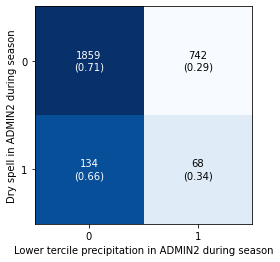

In [37]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb_seas["dry_spell"]
y_predicted = df_comb_seas["below_average"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during season")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
plt.show()

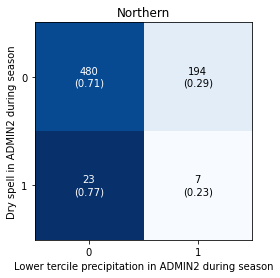

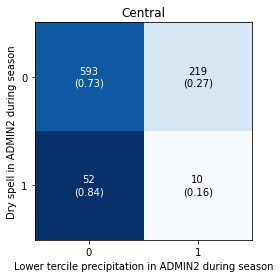

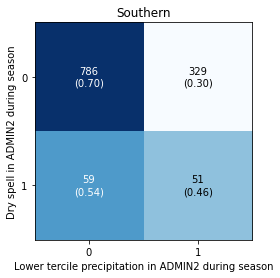

In [38]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
for m in df_comb_seas.ADM1_EN.unique():
    y_target =    df_comb_seas.loc[df_comb_seas.ADM1_EN==m,"dry_spell"]
    y_predicted = df_comb_seas.loc[df_comb_seas.ADM1_EN==m,"below_average"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
#     print(cm)

    fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
    ax.set_ylabel("Dry spell in ADMIN2 during season")
    ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
    ax.set_title(m)
    plt.show()

In [40]:
#mapping of month to season. Computed by rolling sum, i.e. month indicates last month of season
seasons_rolling={3:"JFM",4:"FMA",5:"MAM",6:"AMJ",7:"MJJ",8:"JJA",9:"JAS",10:"ASO",11:"SON",12:"OND",1:"NDJ",2:"DJF"}

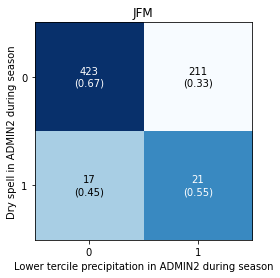

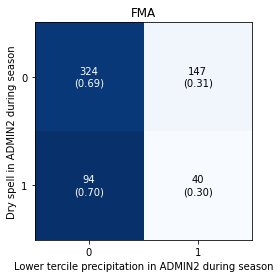

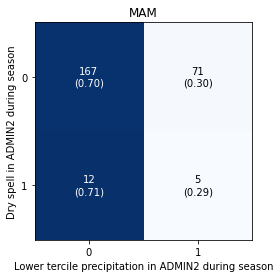

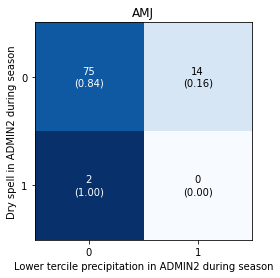

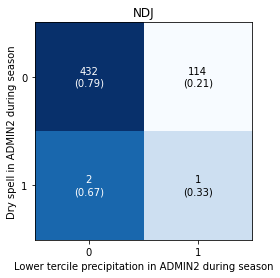

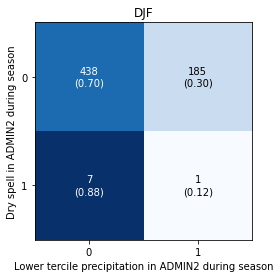

In [41]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
for m in df_comb_seas.sort_values(by="date_month").date_month.dt.month.unique():
    y_target =    df_comb_seas.loc[df_comb_seas.date_month.dt.month==m,"dry_spell"]
    y_predicted = df_comb_seas.loc[df_comb_seas.date_month.dt.month==m,"below_average"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
#     print(cm)

    fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
    ax.set_ylabel("Dry spell in ADMIN2 during season")
    ax.set_xlabel("Lower tercile precipitation in ADMIN2 during season")
    ax.set_title(seasons_rolling[m])
    plt.show()

#### Seasonal dry spells correlation number adm2's

In [43]:
df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum().sort_values(by="dry_spell")

<ipython-input-43-6e5a7885258e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum().sort_values(by="dry_spell")


,dry_spell,below_average
date_month,,
2000-03,0,9
2011-05,0,0
2011-03,0,17
2011-02,0,10
2011-01,0,3
...,...,...
2012-04,12,3
2008-03,17,8
2009-04,18,5


In [44]:
df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum().sort_values(by="below_average")

<ipython-input-44-3db31fe4fb1d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum().sort_values(by="below_average")


,dry_spell,below_average
date_month,,
2007-01,0,0
2019-02,0,0
2019-01,0,0
2018-06,0,0
2018-05,1,0
...,...,...
2016-03,0,26
2004-03,4,27
2004-02,0,28


In [45]:
df_numadm=df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum()

<ipython-input-45-0b5c4afbf2c0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_numadm=df_comb_seas.groupby("date_month")["dry_spell","below_average"].sum()


In [46]:
df_numadm

,dry_spell,below_average
date_month,,
2000-03,0,9
2000-04,0,6
2000-05,0,1
2000-06,0,0
2001-01,0,3
...,...,...
2020-02,1,8
2020-03,1,23
2020-04,1,20


<AxesSubplot:xlabel='dry_spell', ylabel='below_average'>

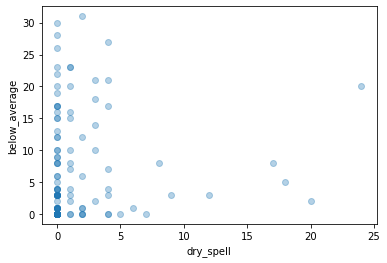

In [56]:
sns.regplot(data = df_numadm, x = 'dry_spell', y = 'below_average', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)

<AxesSubplot:xlabel='dry_spell', ylabel='below_average'>

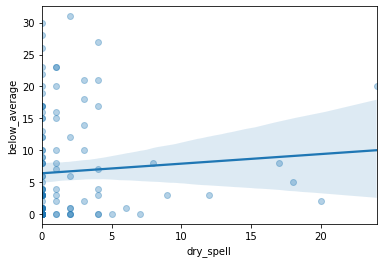

In [53]:
sns.regplot(data = df_numadm, x = 'dry_spell', y = 'below_average', fit_reg = True,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2,)

In [48]:
df_nummonthadm=df_comb_seas.groupby(["date_month","ADM1_EN"],as_index=False)[["dry_spell","below_average"]].sum()

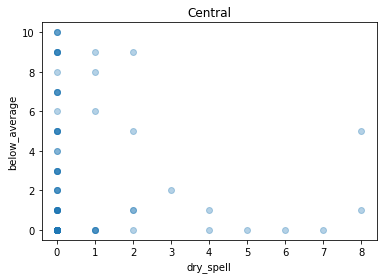

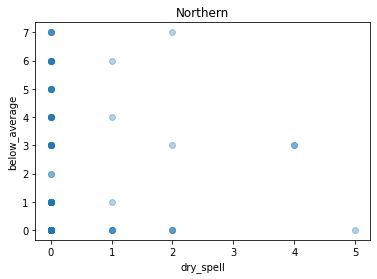

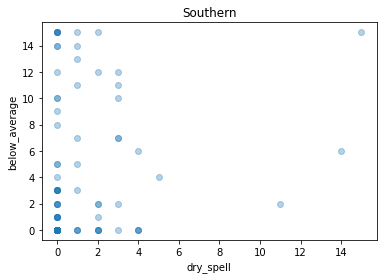

In [59]:
for a in df_nummonthadm.ADM1_EN.unique():
    g=sns.regplot(data = df_nummonthadm[df_nummonthadm.ADM1_EN==a], x = 'dry_spell', y = 'below_average', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)
    g.axes.set_title(a)
    plt.show()

### Observed dryspells and correlation with below average monthly rainfall
**note: the list of dry spells used here is preliminary, thus the correlations will likely change but the processing should be the same**
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with below-average monthly and seasonal rainfall

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

Questions
- Does it make sense to use the datae of dry spell confirmation, or more logical to use the start date?

In [ ]:
df_ds=pd.read_csv(os.path.join(country_data_exploration_dir,"dryspells","mwi_dry_spells_list.csv")) #"../Data/transformed/mwi_dry_spells_list.csv")

In [ ]:
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_confirmation"]=pd.to_datetime(df_ds["dry_spell_confirmation"])
df_ds["ds_conf_m"]=df_ds.dry_spell_confirmation.dt.to_period("M")

In [ ]:
#for now only want to know if a dry spell occured in a given month, so drop those that have several dry spells confirmed within a month
df_ds_drymonth=df_ds.drop_duplicates(["ADM2_EN","ds_conf_m"]).groupby(["ds_conf_m","ADM2_EN"],as_index=False).agg("count")[["ds_conf_m","ADM2_EN","dry_spell_confirmation"]] #["ADM2_EN"]

In [ ]:
df_ds_drymonth

In [ ]:
#merge the dry spells with the info if a month had below average rainfall
#merge on outer such that all dates present in one of the two are included
df_comb=df_ds_drymonth.merge(df_terc,how="outer",left_on=["ds_conf_m","ADM2_EN"],right_on=["date_month","ADM2_EN"])

In [ ]:
#dates that are not present in the dry spell list, but are in the observed rainfall df, thus have no dry spells
df_comb.dry_spell_confirmation=df_comb.dry_spell_confirmation.replace(np.nan,0)

In [ ]:
#contigency matrix rainfall and dry spells for all months
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb["dry_spell_confirmation"]
y_predicted = df_comb["min_cell_touched_se0.33"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during month")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during month")
plt.show()

In [ ]:
#This will eventually be defined by output from R script but for now making rough selection of months generally considered rainy season
df_comb_rainyseas=df_comb[df_comb.date_month.dt.month.isin([11,12,1,2,3,4])]

In [ ]:
#contigency matrix rainfall and dry spells for rainy season months
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb_rainyseas["dry_spell_confirmation"]
y_predicted = df_comb_rainyseas["min_cell_touched_se0.33"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Dry spell in ADMIN2 during month")
ax.set_xlabel("Lower tercile precipitation in ADMIN2 during month")
plt.show()